In [1]:
# Import packages

import math
from pathlib import Path
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D 
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


In [2]:
with open("C:\\Users\\Uriel\\Desktop\\ship_D\\shipsnet.json") as data_file :
    dataset = json.load(data_file)
shipsnet = pd.DataFrame(dataset)
shipsnet.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [3]:
shipsnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [4]:
shipsnet = shipsnet[["data","labels"]]
shipsnet.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [5]:
img_ship = shipsnet["labels"].value_counts()[0]
no_img_ship = shipsnet["labels"].value_counts()[1]

# Affichage
print("Nombre d'images navire : {}".format(img_ship),"\n")
print("Nombre pas d'images navire : {}".format(no_img_ship))

Nombre d'images navire : 3000 

Nombre pas d'images navire : 1000


In [6]:
# On va transformer les informations json en tableau numpy 
# et ensuite les assigner comme variables x et y
import numpy as np
x = np.array(dataset["data"]).astype("uint8")
y = np.array(dataset["labels"]).astype("uint8")

x.shape

(4000, 19200)

Les données actuelles pour chaque image sont une rangée de 19200 points de données aplaties représentant les valeurs RVB de chaque pixel. Nous devons donc les remodeler. 
Après le remodelage, chaque élément de la nouvelle variable x sera constitué,de 3 listes.
Chacune de ces listes sera constituée des valeurs RVB de chaqu pixel pour la longueur et la largeur de l'image.

In [7]:
x_reshaped = x.reshape([-1, 3, 80, 80])
x_reshaped.shape

(4000, 3, 80, 80)

In [8]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0, 2, 3, 1])
x_reshaped.shape

(4000, 80, 80, 3)

On constate que la variable **y** est constituée des valeurs d'étiquettes, **1** ou **0**.
Nous allons chercher à les convertir en matrice de classe binaire.

In [9]:
from tensorflow.keras.utils import to_categorical
y.shape
y_reshaped = to_categorical(y, num_classes = 2)
y_reshaped.shape

(4000, 2)

In [10]:
y_reshaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

**Préparation des données d'entraînement et de test**

**Etape 1** : Normalisation des données x

In [11]:
x_reshaped = x_reshaped / 255

# Normaliser les valeurs RVB du premier pixel de la première image de l'ensemble de données.
x_reshaped[0][0][0]

array([0.32156863, 0.36862745, 0.31372549])

In [12]:
# Maintenant les données sont prêtes à être divisées en données de formation et de test.
# 80 % pour l'entrainnement et 20pour le test

x_train, x_test, y_train, y_test = train_test_split(x_reshaped, y_reshaped, test_size = 0.20, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.20, random_state = 42)

print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)

print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)

print("y_train shape",x_validation.shape)
print("y_train shape",y_validation.shape)

x_train shape (2560, 80, 80, 3)
x_test shape (800, 80, 80, 3)
y_train shape (2560, 2)
y_test shape (800, 2)
y_train shape (640, 80, 80, 3)
y_train shape (640, 2)


### Nous allons utiliser ANN (Réseau neurone artificiel) pour construire notre modèle.

In [13]:
# L'implementation de ANN
from keras.callbacks import EarlyStopping
from keras import callbacks
from tensorflow.keras.models import Sequential


model = Sequential()

model.add(Flatten(input_shape = [80, 80, 3]))
model.add(Dense(200, activation = "relu"))
model.add(Dense(150, activation = "relu"))
model.add(Dense(2, activation = "sigmoid"))


model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)


#model.compile(loss = "categorical_crossentropy" , optimizer = "Adam" , metrics = ["accuracy"])

#earlstopping = EarlyStopping(monotor = "val_loss", mode = "min", patience = 10, restore_best_weights = True)

#model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
# Compilation du modèle

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 19200)             0         
                                                                 
 dense (Dense)               (None, 200)               3840200   
                                                                 
 dense_1 (Dense)             (None, 150)               30150     
                                                                 
 dense_2 (Dense)             (None, 2)                 302       
                                                                 
Total params: 3,870,652
Trainable params: 3,870,652
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(x_train, y_train, epochs = 50, validation_data=(x_validation, y_validation), callbacks = [earlystopping])


Epoch 1/50
80/80 [==============================] - 72s 58ms/step - loss: 1.2263 - accuracy: 0.7629 - val_loss: 0.4123 - val_accuracy: 0.8297
Epoch 2/50
80/80 [==============================] - 3s 42ms/step - loss: 0.3468 - accuracy: 0.8641 - val_loss: 0.2979 - val_accuracy: 0.8828
Epoch 3/50
80/80 [==============================] - 3s 41ms/step - loss: 0.2938 - accuracy: 0.8879 - val_loss: 0.2782 - val_accuracy: 0.8891
Epoch 4/50
80/80 [==============================] - 3s 41ms/step - loss: 0.3652 - accuracy: 0.8609 - val_loss: 0.2646 - val_accuracy: 0.9000
Epoch 5/50
80/80 [==============================] - 3s 42ms/step - loss: 0.3477 - accuracy: 0.8691 - val_loss: 0.3315 - val_accuracy: 0.8531
Epoch 6/50
80/80 [==============================] - 3s 43ms/step - loss: 0.2802 - accuracy: 0.8941 - val_loss: 0.2839 - val_accuracy: 0.8938
Epoch 7/50
80/80 [==============================] - 3s 41ms/step - loss: 0.2548 - accuracy: 0.9023 - val_loss: 0.2638 - val_accuracy: 0.9016
Epoch 8/50
8

In [16]:
# Evaluation du model

model.evaluate(x_test,y_test)

25/25 [==============================] - 0s 15ms/step - loss: 0.2268 - accuracy: 0.9100


[0.22675158083438873, 0.9100000262260437]

Text(0.5, 1.0, 'Courbe de precision(Accuracy)')

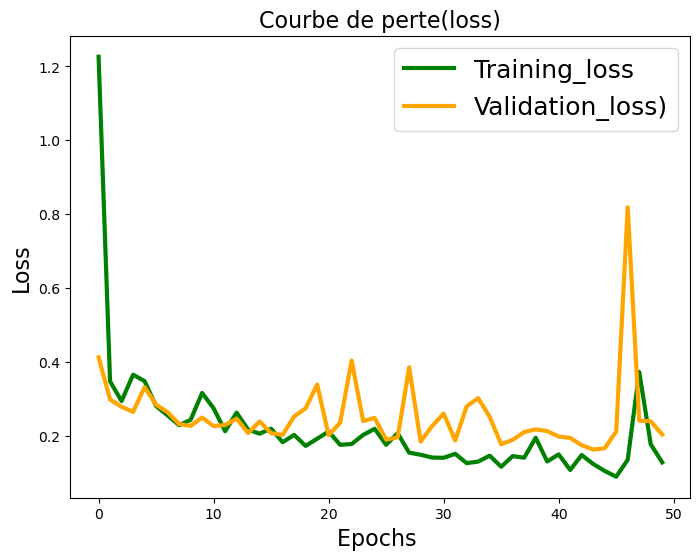

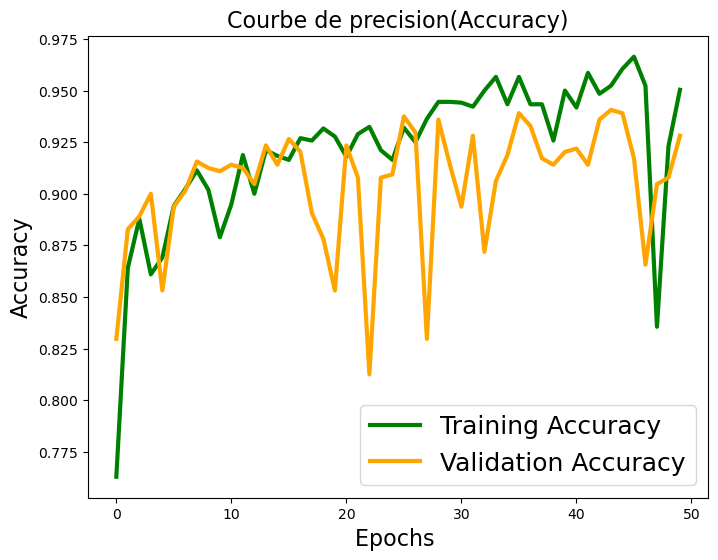

In [17]:
# Courbe de perte
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'green',linewidth=3.0)
plt.plot(history.history['val_loss'],'orange',linewidth=3.0)
plt.legend(['Training_loss', 'Validation_loss)'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Courbe de perte(loss)',fontsize=16)

# Courbe de precision(Accuracy)
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'green',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'orange',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Courbe de precision(Accuracy)',fontsize=16)

25/25 [==============================] - 1s 26ms/step

Test Accuracy Score :  0.91 



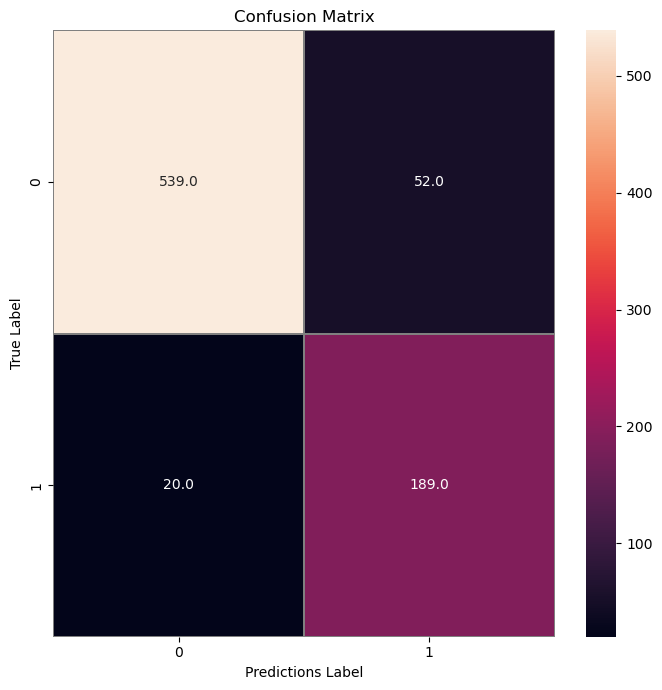

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

Y_pred = model.predict(x_test)
# Convertir les classes de prédictions en un vecteur chaud.
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convertissez les observations de validation en un vecteur chaud.
Y_true = np.argmax(y_test,axis = 1) 
# Calculer la matrice de confusion

print("\n""Test Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred_classes),"\n")


confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predictions Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()

- TP : indique que les predictions et les valeurs réelles sont positives
- TN : indique que les prediction et les valeurs réelles sont toutes les deux négatives
- FP : indique que la prediction positive est contraire à la valeur réelle qui est négative
- FN : indique que les predictions sont négatives alors que les valeurs réelles sont positives



Nous allons tester notre model

In [19]:
prediction = model.predict(x_test)
pd.Series(prediction[1], index=[" Image sans navire", "Image avec navire"])

25/25 [==============================] - 1s 18ms/step


 Image sans navire    0.993920
Image avec navire     0.086055
dtype: float32

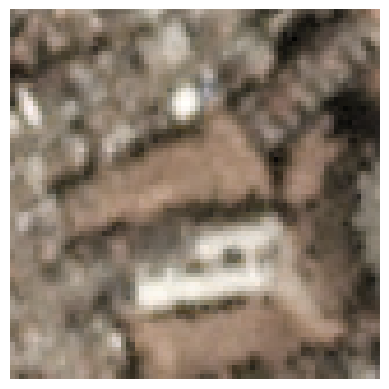

In [20]:
plt.imshow(x_test[1])
plt.axis("off")
plt.show()